## Zorah Zafari, MACRO PSET 4 (in collaboration with Bridget Galaty)

## Produtivity Shocks in the Three Equation Model 

The log-linearized NK model boils down to three equations:

$$
\begin{align*}
\hat{y}_t &=-\sigma[\hat{i}_t-E_t\{\hat{\pi}_{t+1}\}]+E_t\{\hat{y}_{t+1}\} \\
\hat{\pi}_t&=\kappa (\hat{y}_t-\hat{y}_t^{flex}) +\beta E_t \{\hat{\pi}_{t+1}\} \\
\hat{i}_t&=\phi_\pi\hat{\pi}_t+v_t 
\end{align*} 
$$

with $\hat{y}_t^{flex}=\frac{1+\varphi}{\gamma+\varphi}\hat{a}_t$.
For this part assume that $v_t=0$ and that $\hat{a}_t = \rho_a \hat{a}_{t-1} + \epsilon_t$.

In part (a) we use the method of undetermined coefficients, solve for $\hat{y}_t$ and $\hat{\pi}_t$ as a function of $\hat{a}_t$.
$$
\begin{align*}
\hat{\pi}_t= \eta_{\pi a} \hat{a}_t &= \frac{-\kappa \left( 1-\rho_a \right) \left(\frac{1+\varphi}{\gamma+\varphi}\right) \hat{a}_t}{(1-\rho_a)(1-\beta\rho_a)+\sigma(\phi_{\pi}-\rho_{a})\kappa} \\
\hat{y}_t=\eta_{ya} \hat{a}_t & = \frac{\kappa \sigma \left(\phi_\pi-\rho_a \right) \left(\frac{1+\varphi}{\gamma+\varphi}\right) \hat{a}_t}{(1-\rho_a)(1-\beta\rho_a)+\sigma(\phi_{\pi}-\rho_{a})\kappa}
\end{align*}
$$

We now want to plot the impulse response function for $\hat{y}_t, \hat{\pi}_t,\hat{y}_t^{flex},\hat{y}_t-\hat{y}_t^{flex},\hat{i}_t,\mathbb{E}_t\hat{r}_{t+1},\hat{n}_{t},\hat{a}_t$ to a one unit shock to $\hat{a}_t$. 

Using the following parameter values:
$\beta=0.99,\sigma=1,\kappa=0.1,\rho_a=0.8,\phi_\pi=1.5, \gamma=1$


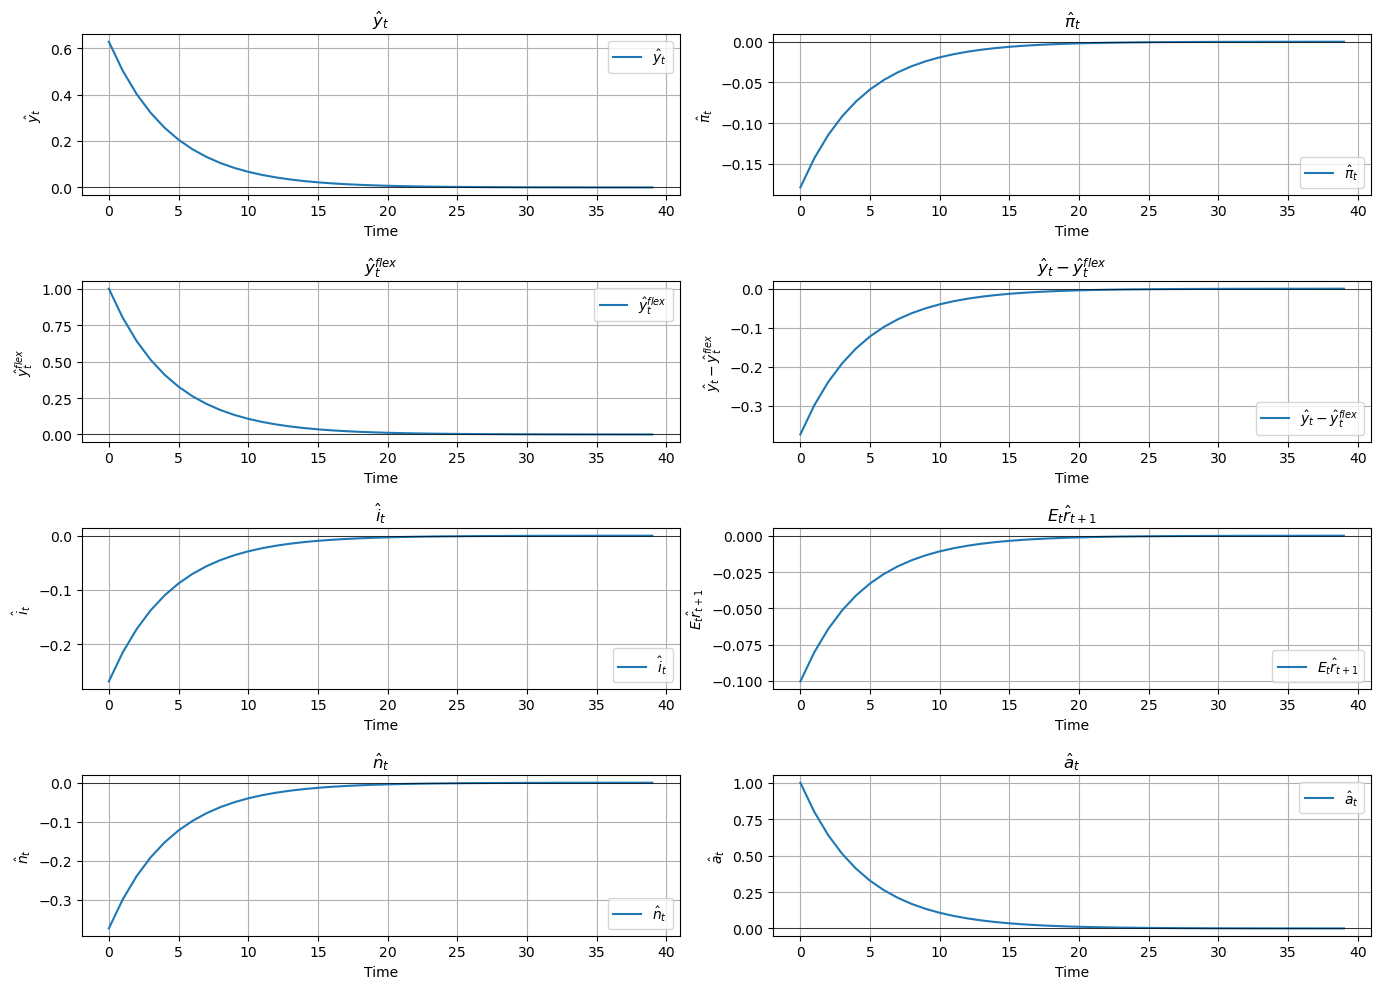

In [73]:
# problem 1 b 

import numpy as np
import matplotlib.pyplot as plt

# Define parameters
beta = 0.99
sigma = 1
kappa = 0.1
rho_a = 0.8
phi_pi = 1.5

# Other parameters 
varphi = 0.5  # assumption
gamma = 1  #(sigma = 1/gamma)


# Define the AR(1) process for at
def generate_a_t(rho_a, T):
    a_t = np.zeros(T)
    a_t[0] = 1  # initial shock
    for t in range(1, T):
        a_t[t] = rho_a * a_t[t-1]
    return a_t

# Time horizon
T = 40

# Generate the time series for at
a_t = generate_a_t(rho_a, T)

# Calculate yt, pi_t, yt_flex

# Coefficients for the given formulas
coef_y = (sigma * kappa * (rho_a - phi_pi) * (rho_a - 1) * (1 + varphi)) / \
         ((1 - rho_a) * ((1 - rho_a) * (1 - beta * rho_a) - kappa * (rho_a - phi_pi)) * (gamma + varphi))

coef_pi = (kappa * (rho_a - 1) * (1 + varphi)) / \
          (((1 - rho_a) * (1 - beta * rho_a) - kappa * (rho_a - phi_pi)) * (gamma + varphi))

coef_y_flex = (1 + varphi) / (gamma + varphi)

# Calculate the responses over time
y_t = coef_y * a_t
pi_t = coef_pi * a_t
y_t_flex = coef_y_flex * a_t
y_t_gap = y_t - y_t_flex

# Define it, Et_pit+1 Et_rt+1, nt 
i_t = phi_pi * pi_t  
Et_pit1 = coef_pi * rho_a * np.roll(a_t, -1) # Expected inflation on t+1
Et_pit1[-1] = 0  # Correct the last value
Et_rt1 = np.roll(i_t, -1) - Et_pit1  # Expected real interest rate on t+1
Et_rt1[-1] = 0  # Correct the last value
n_t = y_t - a_t  # Using Galli

# Plot the impulse response functions
plt.figure(figsize=(14, 10))

variables = [y_t, pi_t, y_t_flex, y_t_gap, i_t, Et_rt1, n_t, a_t]
labels = ['$\\hat{y}_t$', '$\\hat{\\pi}_t$', '$\\hat{y}_t^{flex}$', '$\\hat{y}_t - \\hat{y}_t^{flex}$', 
          '$\\hat{i}_t$', '$E_t\\hat{r}_{t+1}$', '$\\hat{n}_t$', '$\\hat{a}_t$']

for i, (var, label) in enumerate(zip(variables, labels)):
    plt.subplot(4, 2, i + 1)
    plt.plot(var, label=label)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.title(label)
    plt.xlabel('Time')
    plt.ylabel(label)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

<SimpleBlock 'nkpc'>
Inputs: ['pi', 'beta', 'kappa', 'phi_pi', 'gamma', 'a']
Outputs: ['y', 'yflex', 'yyflexdiff', 'n']
<Model 'NK'>
Blocks: [<SimpleBlock 'central_bank'>, <SimpleBlock 'nkpc'>, <SimpleBlock 'mkt_clearing'>]
<JacobianDict outputs=['pi', 'y', 'yflex', 'yyflexdiff', 'n', 'i', 'euler', 'r', 'c'], inputs=['a']>


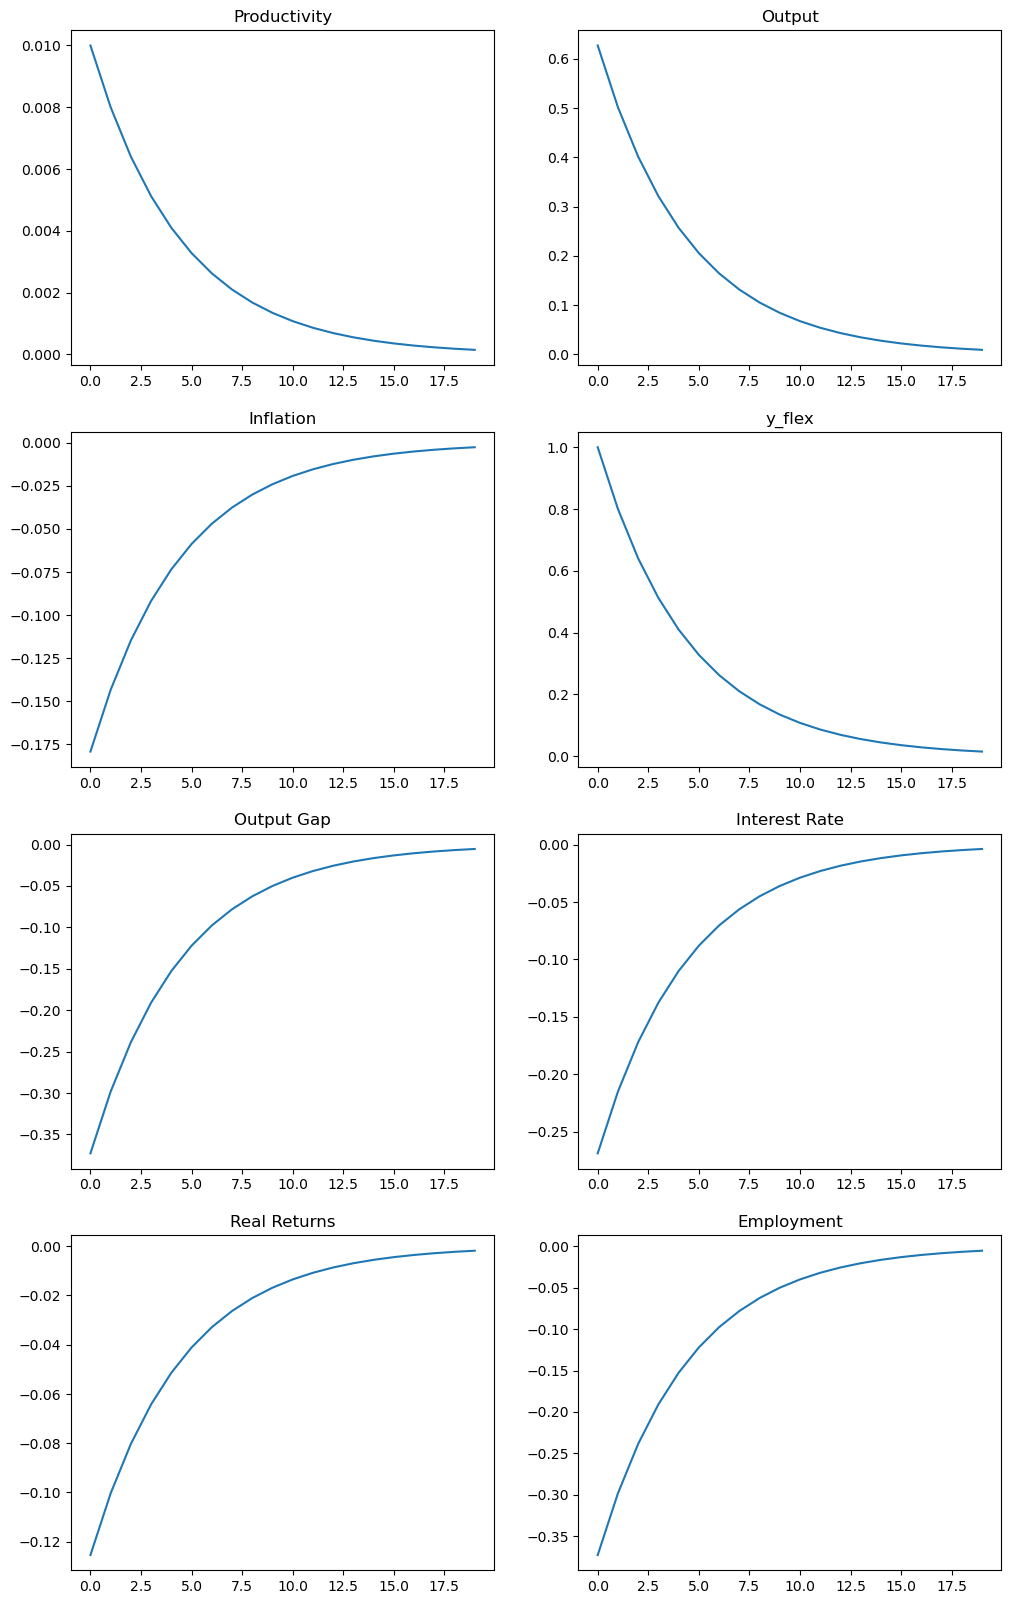

In [75]:
## Problem 1 - Part d
from sequence_jacobian import simple, create_model, solved

@simple
def nkpc(pi, beta, kappa, phi_pi, gamma, a):
    yflex = ((1 + phi_pi) * a) / (gamma + phi_pi)
    y = yflex + 1 / kappa * (pi - beta * pi(+1))
    yyflexdiff = y - yflex
    n = y - a
    return y, yflex, yyflexdiff, n

@simple
def central_bank(pi, phi_pi):
    i = phi_pi * pi
    return i

@simple
def mkt_clearing(y, i, pi, gamma):
    euler = gamma * y + i - pi(+1) - gamma * y(+1)
    r = i - pi(+1)
    c = y
    return euler, r, c

print(nkpc)
print(f"Inputs: {nkpc.inputs}")
print(f"Outputs: {nkpc.outputs}")

nk = create_model([nkpc, central_bank, mkt_clearing], name="NK")

print(nk)
print(f"Blocks: {nk.blocks}")

unknowns = ['pi']
targets = ['euler']
inputs = ['a']

# steady state values
calibration = {'yflex': 0, 'a': 0, 'y': 0, 'c': 0, 'r': 0, 'i': 0, 'gamma': gamma, 'beta': beta, 'phi_pi': phi_pi, 'kappa': kappa}

# solve for steady state (we know it, but running this routine helps us check for mistakes)
unknowns_ss = {'pi': 0}
targets_ss = { "euler": 0}

ss = nk.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="broyden_custom")

# checking that we are in the steady state that we expect
assert np.allclose(ss['pi'], 0)
assert np.allclose(ss['euler'], 0)


G = nk.solve_jacobian(ss, unknowns, targets, inputs, T=300)

print(G)

T, Tplot, impact, rho, news = 300, 20, 0.01, 0.8, 10
da = np.empty((T, 1))
da[:, 0] = impact * rho**np.arange(T)


# plot responses=
plotset = ['a', 'y', 'pi', 'yflex', 'yyflexdiff', 'i', 'r', 'n']
fig, ax = plt.subplots(4, 2, figsize=(12, 20))
for i, var in enumerate(plotset):
    if var == 'a':
        irf1 = da[:Tplot]
    else:
        irf1 = 100 * (G[var]['a'] @ da)[:Tplot]
    axi = ax[i // 2, i % 2]
    ax[0, 0].set_title('Productivity')
    ax[0, 1].set_title('Output')
    ax[1, 0].set_title('Inflation')
    ax[1, 1].set_title('y_flex')
    ax[2, 0].set_title('Output Gap')
    ax[2, 1].set_title('Interest Rate')
    ax[3, 0].set_title('Real Returns')
    ax[3, 1].set_title('Employment')
    axi.plot(irf1, label="kappa=0.1")



<Model 'NK'>
Blocks: [<SimpleBlock 'central_bank'>, <SimpleBlock 'hh'>, <SolvedBlock 'firm'>, <SimpleBlock 'firm2'>, <SimpleBlock 'mkt_clearing'>]
Steady-state values:
v: 1.0
a: 1.0
y: 0.9486832980505823
r: 1.01010101010101
sdf: 0.9900000000000001
wp: 0.9000000000001299
q: 1.0101010101010095
gamma: 1
beta: 0.99
phi_pi: 1.5
theta: 0.25
varphi: 1
chi: 1
mu: 0.1111111111111111
epsilon: 10
n: 0.9486832980505823
c: 0.9486832980505823
pi: 0.9999999999999996
f1: 1.2607087017285288
f2: 1.260708701728347
F1: 0.0
F2: 0.0
pstar: 1.0000000000001443
fisher: 0.0
output: 0.0
inflation: -9.752199048307375e-13
fisher residual: 0.0
output residual: 0.0
inflation residual: -9.752199048307375e-13
<JacobianDict outputs=['n', 'c', 'pi', 'wp', 'sdf', 'r', 'F1', 'F2', 'y', 'f1', 'f2', 'pstar', 'q', 'fisher', 'output', 'inflation'], inputs=['a', 'v']>


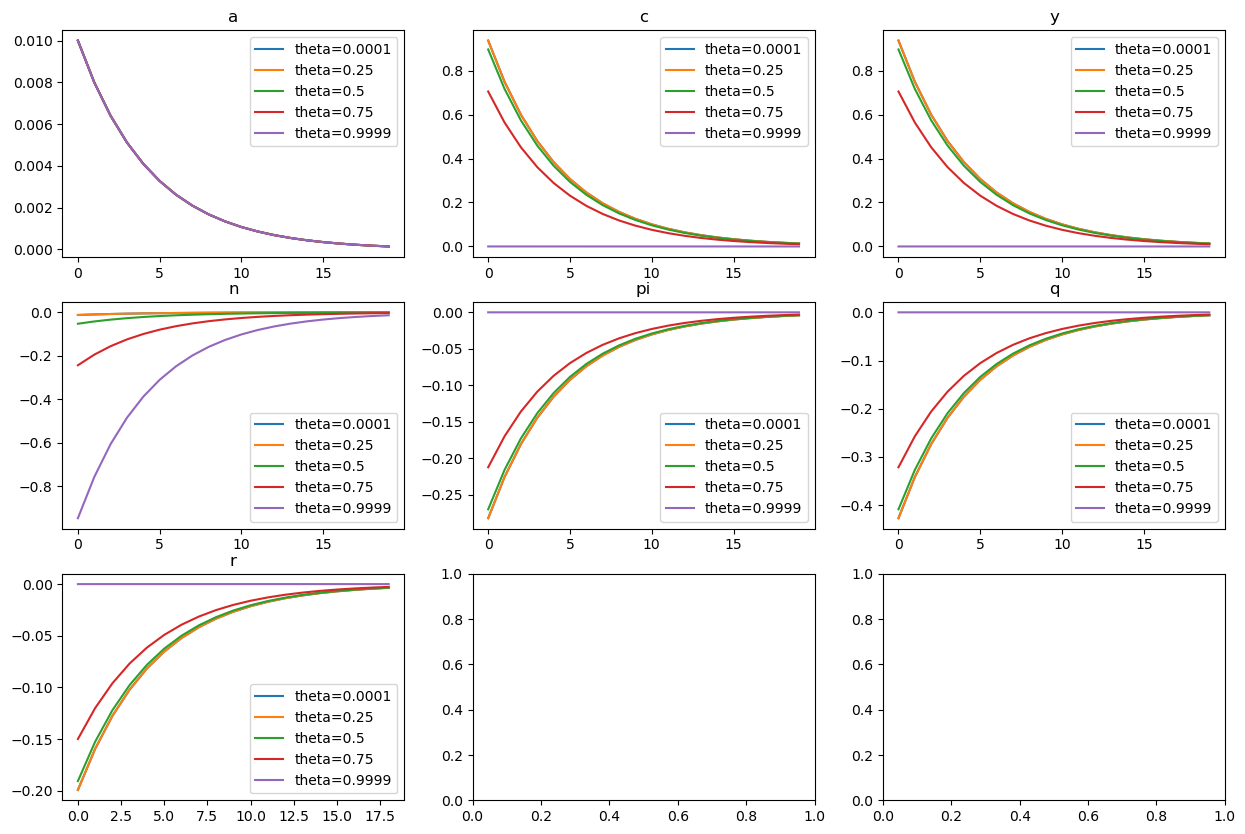

In [69]:
#question 2 

# Load in Packages
import numpy as np
import matplotlib.pyplot as plt
from sequence_jacobian import simple, create_model, solved

## Problem 2 - Part f
# Set Parameters
beta = 0.99
gamma = 1
varphi = 1
chi = 1
epsilon = 10
rho_a = 0.8
phi_pi = 1.5
phi_y = 0 
mu = 1/(epsilon-1)
theta_ = [0.0001, 0.25, 0.5, 0.75, 0.9999]

theta = theta_[1]

@simple
def hh(c, n, varphi, gamma, beta, chi):
    wp = chi*(n**varphi)/(c**(-gamma))
    sdf = beta*(c**(-gamma))/(c(-1)**(-gamma))
    r = 1/(beta*(c**(-gamma))/(c(-1)**(-gamma)))
    return wp, sdf, r

@solved(unknowns={'f1': (1-mu)*chi/(1-theta*beta), 'f2': 1/(1-theta*beta)}, targets=['F1', 'F2'], solver="broyden_custom")
def firm(sdf, wp, a, pi, n, mu, theta, epsilon, f1, f2):    
    y = a*n
    F1 = (1 + mu) * (a * n) * (wp / a) + theta * (pi(+1) ** epsilon) * sdf(+1) * f1(+1) - f1
    F2 = (a * n) + theta * (pi(+1) ** (epsilon - 1)) * sdf(+1) * f2(+1) - f2
    return F1, F2, y

@simple
def firm2(f1, f2):
    pstar = f1 / f2
    return pstar

@simple
def central_bank(pi, v, phi_pi, beta):
    q = (1 / beta) * (pi ** phi_pi) * v
    return q

@simple
def mkt_clearing(y, c, pstar, q, r, pi, theta, epsilon):
    output = y - c
    inflation  = theta*(pi**(epsilon-1))+(1-theta)*(pstar**(1-epsilon)) - 1
    fisher = r(+1) - q/pi(+1)
    return fisher, output, inflation

nk = create_model([hh, firm, firm2, central_bank, mkt_clearing], name="NK")

print(nk)
print(f"Blocks: {nk.blocks}")

# steady state values
calibration = {'v': 1.0, 'a': 1.0, 'y': 1.0, 'r': 1.0/beta, 'sdf': beta, 'wp': chi, 'q': 1.0 / beta, 'gamma': gamma, 'beta': beta, 'phi_pi': phi_pi, 'theta': theta, 'varphi': varphi, 'chi': chi, 'mu': mu, 'epsilon': epsilon}

# solve for steady state (we know it, but running this routine helps us check for mistakes)
unknowns_ss = {'n': 1.0, 'c': 1.0, 'pi': 1.0}
targets_ss = {'fisher': 0.0, 'output': 0.0, 'inflation': 0.0}

ss = nk.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="broyden_custom")

# Print steady-state results
print("Steady-state values:")
for key, value in ss.items():
    print(f"{key}: {value}")

# Check that the residuals are close to zero
fisher_residual = ss['fisher']
output_residual = ss['output']
inflation_residual = ss['inflation']
print(f"fisher residual: {fisher_residual}")
print(f"output residual: {output_residual}")
print(f"inflation residual: {inflation_residual}")

unknowns = ['n', 'c', 'pi']
targets = ['fisher', 'output', 'inflation']
inputs = ['a', 'v']

G = nk.solve_jacobian(ss, unknowns, targets, inputs, T=300)

print(G)

calibration_copies = {}
# change calibration
for i in range(1,len(theta_)):
    calibration_i = calibration.copy()
    calibration_i['theta'] = theta_[i]

    # calculate new steady state
    ss_i = nk.solve_steady_state(calibration_i, unknowns_ss, targets_ss, solver="broyden_custom")

    # calculate new Jacobian
    G_i = nk.solve_jacobian(ss_i, unknowns, targets, inputs, T=300)

    calibration_copies[f'G_{i}'] = G_i

T, Tplot, impact, rho_a = 300, 20, 0.01, rho_a
da = np.empty((T, 1))
da[:, 0] = impact * rho_a**np.arange(T)

# plot responses
plotset = ['a','c','y','n','pi','q','r']
fig, ax = plt.subplots(3, 3, figsize=(15, 10))
for i, var in enumerate(plotset):
    if var == 'a':
        irf1 = da[:Tplot]
        irf2 = da[:Tplot]
        irf3 = da[:Tplot]
        irf4 = da[:Tplot]
        irf5 = da[:Tplot]
    elif var == 'r':
        irf1 = 100 * (G[var]['a'] @ da)[1:Tplot]
        irf2 = 100 * (calibration_copies['G_1'][var]['a'] @ da)[1:Tplot]
        irf3 = 100 * (calibration_copies['G_2'][var]['a'] @ da)[1:Tplot]
        irf4 = 100 * (calibration_copies['G_3'][var]['a'] @ da)[1:Tplot]
        irf5 = 100 * (calibration_copies['G_4'][var]['a'] @ da)[1:Tplot]
    else:
        irf1 = 100 * (G[var]['a'] @ da)[:Tplot]
        irf2 = 100 * (calibration_copies['G_1'][var]['a'] @ da)[:Tplot]
        irf3 = 100 * (calibration_copies['G_2'][var]['a'] @ da)[:Tplot]
        irf4 = 100 * (calibration_copies['G_3'][var]['a'] @ da)[:Tplot]
        irf5 = 100 * (calibration_copies['G_4'][var]['a'] @ da)[:Tplot]
    axi = ax[i // 3, i % 3]
    axi.plot(irf1, label=f"theta={theta_[0]}")
    axi.plot(irf2, label=f"theta={theta_[1]}")
    axi.plot(irf3, label=f"theta={theta_[2]}")
    axi.plot(irf4, label=f"theta={theta_[3]}")
    axi.plot(irf5, label=f"theta={theta_[4]}")
    axi.set_title(f"{var}")
    axi.xlabel = "quarters"
    axi.ylabel = "% deviation"
    axi.legend()

